C:\Users\USER\AppData\Local\Temp\ipykernel_16136\1058016802.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\USER\AppData\Local\Temp\ipykernel_16136\1058016802.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


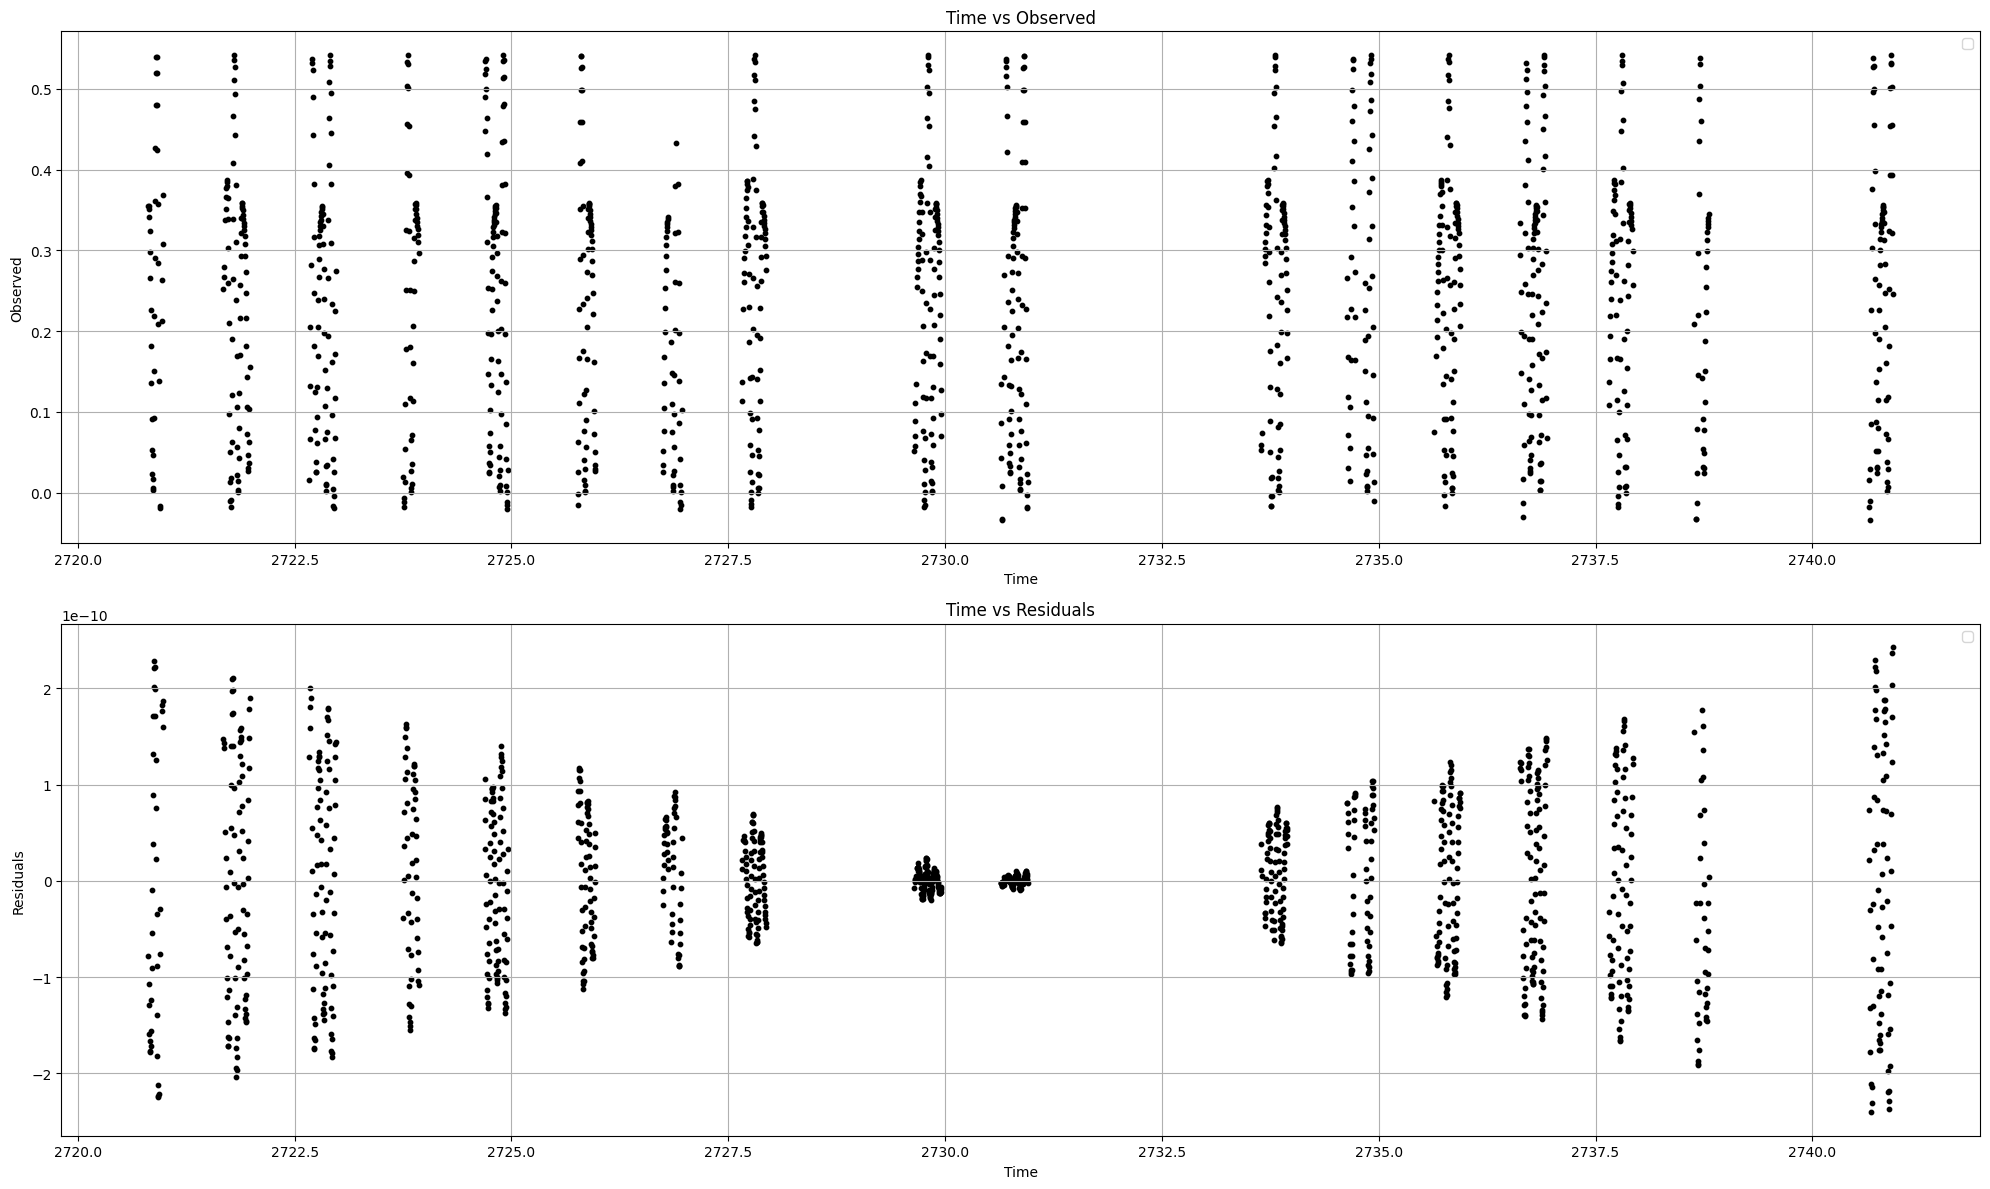

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar archivo .fou (columnas: frecuencia, amplitud, power)
data1 = np.loadtxt("Final data.dat")

time = data1[:, 0]
obs = data1[:, 1]
calculated=data1[:,2]
reesiduals=data1[:,3]

# Crear figura
plt.figure(figsize=(20, 12))
plt.subplot(2,1,1)
plt.scatter(time, obs,s=10,color="black")

plt.xlabel("Time")
plt.ylabel("Observed")
plt.title("Time vs Observed")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(2,1,2)
plt.scatter(time,reesiduals,s=10,color="black")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Time vs Residuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import pandas as pd

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 10)

# ===== CARGAR DATOS =====
print("Cargando datos...")

# Cargar datos principales
final_data = pd.read_csv('Final data', sep='\s+', header=0)
print(f"Final data columnas: {final_data.columns.tolist()}")

# Cargar periodos
periodos = pd.read_csv('Periodos', sep='\s+', header=0)
print(f"Periodos columnas: {periodos.columns.tolist()}")

# Cargar transformadas de Fourier
tf_observed = pd.read_csv('TF.fou', sep='\s+', header=None, names=['Frequency', 'Amplitude'])
tf_residuals = pd.read_csv('TF Residuals.fou', sep='\s+', header=None, names=['Frequency', 'Amplitude'])

# Extraer datos
time = final_data.iloc[:, 0].values
observed = final_data.iloc[:, 1].values
calculated = final_data.iloc[:, 2].values
residuals = final_data.iloc[:, 3].values

# Obtener frecuencias y parámetros de los periodos
freq1 = periodos.iloc[0, 0]  # Frecuencia principal (datos observados)
amp1 = periodos.iloc[0, 1]   # Amplitud
phase1 = periodos.iloc[0, 2] # Fase

freq2 = periodos.iloc[1, 0]  # Frecuencia secundaria (residuos)
amp2 = periodos.iloc[1, 1]
phase2 = periodos.iloc[1, 2]

print(f"\nFrecuencia principal: {freq1:.6f} c/d")
print(f"Amplitud: {amp1:.6f}, Fase: {phase1:.6f}")
print(f"\nFrecuencia secundaria: {freq2:.6f} c/d")
print(f"Amplitud: {amp2:.6f}, Fase: {phase2:.6f}")

# ===== DEFINIR MODELOS =====

def fourier_series(t, mean, A1, f1, phi1, A2, f2, phi2):
    """Modelo de serie de Fourier con 2 componentes"""
    return mean + A1 * np.sin(2*np.pi*f1*t + phi1) + A2 * np.sin(2*np.pi*f2*t + phi2)

def single_fourier(t, mean, A, f, phi):
    """Modelo de Fourier simple"""
    return mean + A * np.sin(2*np.pi*f*t + phi)

def multi_fourier(t, mean, *params):
    """Modelo multi-frecuencia (hasta 5 componentes)"""
    result = mean
    n_components = len(params) // 3
    for i in range(n_components):
        A = params[3*i]
        f = params[3*i + 1]
        phi = params[3*i + 2]
        result += A * np.sin(2*np.pi*f*t + phi)
    return result

# ===== AJUSTE DE CURVAS =====

print("\n" + "="*60)
print("AJUSTANDO MODELOS A LOS DATOS")
print("="*60)

# Modelo 1: Usar parámetros de Period04 (2 frecuencias)
mean_obs = np.mean(observed)
model1 = fourier_series(time, mean_obs, amp1, freq1, phase1, amp2, freq2, phase2)
residuals1 = observed - model1
rms1 = np.sqrt(np.mean(residuals1**2))
r2_1 = 1 - (np.sum(residuals1**2) / np.sum((observed - mean_obs)**2))

print(f"\nModelo 1 (Period04 - 2 frecuencias):")
print(f"  RMS: {rms1:.6f}")
print(f"  R²: {r2_1:.6f}")

# Modelo 2: Optimizar parámetros con curve_fit (2 frecuencias)
try:
    p0 = [mean_obs, amp1, freq1, phase1, amp2, freq2, phase2]
    bounds = ([min(observed), 0, 0, -2*np.pi, 0, 0, -2*np.pi],
              [max(observed), 1, 10, 2*np.pi, 1, 10, 2*np.pi])
    
    popt2, pcov2 = curve_fit(fourier_series, time, observed, p0=p0, bounds=bounds, maxfev=5000)
    model2 = fourier_series(time, *popt2)
    residuals2 = observed - model2
    rms2 = np.sqrt(np.mean(residuals2**2))
    r2_2 = 1 - (np.sum(residuals2**2) / np.sum((observed - mean_obs)**2))
    
    print(f"\nModelo 2 (Optimizado - 2 frecuencias):")
    print(f"  RMS: {rms2:.6f}")
    print(f"  R²: {r2_2:.6f}")
    print(f"  Frecuencia 1: {popt2[2]:.6f} c/d")
    print(f"  Frecuencia 2: {popt2[5]:.6f} c/d")
except Exception as e:
    print(f"\nModelo 2 falló: {e}")
    popt2 = None

# Modelo 3: Encontrar frecuencias dominantes del espectro de Fourier
fft_freq = np.fft.fftfreq(len(time), np.mean(np.diff(time)))
fft_power = np.abs(np.fft.fft(observed - mean_obs))
positive_freq = fft_freq > 0
fft_freq_pos = fft_freq[positive_freq]
fft_power_pos = fft_power[positive_freq]

# Encontrar picos principales
sorted_indices = np.argsort(fft_power_pos)[::-1]
top_freqs = fft_freq_pos[sorted_indices[:3]]

print(f"\nModelo 3 (FFT - frecuencias detectadas):")
print(f"  Top 3 frecuencias: {top_freqs}")

# ===== ESTADÍSTICAS COMPARATIVAS =====

print("\n" + "="*60)
print("ANÁLISIS ESTADÍSTICO DE RESIDUOS")
print("="*60)

def analyze_residuals(residuals, name):
    print(f"\n{name}:")
    print(f"  Media: {np.mean(residuals):.6f}")
    print(f"  Desviación estándar: {np.std(residuals):.6f}")
    print(f"  Mínimo: {np.min(residuals):.6f}")
    print(f"  Máximo: {np.max(residuals):.6f}")
    print(f"  Mediana: {np.median(residuals):.6f}")
    
    # Test de normalidad
    _, p_value = stats.shapiro(residuals[:min(5000, len(residuals))])
    print(f"  Normalidad (Shapiro-Wilk p-value): {p_value:.6f}")

analyze_residuals(residuals, "Residuos Period04")
analyze_residuals(residuals1, "Residuos Modelo 1")
if popt2 is not None:
    analyze_residuals(residuals2, "Residuos Modelo 2")

# ===== VISUALIZACIÓN =====

fig = plt.figure(figsize=(16, 12))

# 1. Curva de luz con ajustes
ax1 = plt.subplot(3, 2, 1)
ax1.scatter(time, observed, s=10, alpha=0.6, label='Observado', color='blue')
ax1.plot(time, calculated, 'r-', linewidth=1, label='Period04', alpha=0.7)
ax1.plot(time, model1, 'g-', linewidth=1, label='Modelo 1', alpha=0.7)
if popt2 is not None:
    ax1.plot(time, model2, 'm-', linewidth=1, label='Modelo 2', alpha=0.7)
ax1.set_xlabel('Tiempo (días)')
ax1.set_ylabel('Magnitud')
ax1.set_title('Curva de Luz con Ajustes')
ax1.legend()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

# 2. Curva de luz plegada (phase folded)
ax2 = plt.subplot(3, 2, 2)
period1 = 1.0 / freq1
phase = (time % period1) / period1
sorted_idx = np.argsort(phase)
ax2.scatter(phase, observed, s=10, alpha=0.6, color='blue')
phase_model = np.linspace(0, 1, 500)
time_model = phase_model * period1
model_folded = fourier_series(time_model, mean_obs, amp1, freq1, phase1, amp2, freq2, phase2)
ax2.plot(phase_model, model_folded, 'r-', linewidth=2, label='Modelo')
ax2.set_xlabel('Fase')
ax2.set_ylabel('Magnitud')
ax2.set_title(f'Curva Plegada (P = {period1:.6f} d)')
ax2.legend()
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

# 3. Residuos vs tiempo
ax3 = plt.subplot(3, 2, 3)
ax3.scatter(time, residuals, s=10, alpha=0.6, label='Period04', color='blue')
ax3.scatter(time, residuals1, s=10, alpha=0.6, label='Modelo 1', color='green')
if popt2 is not None:
    ax3.scatter(time, residuals2, s=10, alpha=0.6, label='Modelo 2', color='magenta')
ax3.axhline(y=0, color='r', linestyle='--', linewidth=1)
ax3.set_xlabel('Tiempo (días)')
ax3.set_ylabel('Residuos')
ax3.set_title('Residuos vs Tiempo')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Transformada de Fourier de datos observados
ax4 = plt.subplot(3, 2, 4)
ax4.plot(tf_observed['Frequency'], tf_observed['Amplitude'], 'b-', linewidth=1)
ax4.axvline(x=freq1, color='r', linestyle='--', linewidth=1, label=f'f1={freq1:.4f}')
ax4.axvline(x=freq2, color='g', linestyle='--', linewidth=1, label=f'f2={freq2:.4f}')
ax4.set_xlabel('Frecuencia (c/d)')
ax4.set_ylabel('Amplitud')
ax4.set_title('Transformada de Fourier - Datos Observados')
ax4.set_xlim(0, 5)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Transformada de Fourier de residuos
ax5 = plt.subplot(3, 2, 5)
ax5.plot(tf_residuals['Frequency'], tf_residuals['Amplitude'], 'purple', linewidth=1)
ax5.set_xlabel('Frecuencia (c/d)')
ax5.set_ylabel('Amplitud')
ax5.set_title('Transformada de Fourier - Residuos')
ax5.set_xlim(0, 5)
ax5.grid(True, alpha=0.3)

# 6. Histograma de residuos
ax6 = plt.subplot(3, 2, 6)
ax6.hist(residuals, bins=30, alpha=0.5, label='Period04', color='blue', density=True)
ax6.hist(residuals1, bins=30, alpha=0.5, label='Modelo 1', color='green', density=True)
if popt2 is not None:
    ax6.hist(residuals2, bins=30, alpha=0.5, label='Modelo 2', color='magenta', density=True)
ax6.set_xlabel('Residuos')
ax6.set_ylabel('Densidad')
ax6.set_title('Distribución de Residuos')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_estrella_binaria.png', dpi=300, bbox_inches='tight')
print("\n¡Gráfico guardado como 'analisis_estrella_binaria.png'!")
plt.show()

# ===== RESUMEN FINAL =====

print("\n" + "="*60)
print("RESUMEN - MEJOR MODELO")
print("="*60)

models_rms = [('Period04 (calculado)', np.sqrt(np.mean(residuals**2))),
              ('Modelo 1 (2 freq)', rms1)]

if popt2 is not None:
    models_rms.append(('Modelo 2 (optimizado)', rms2))

best_model = min(models_rms, key=lambda x: x[1])
print(f"\nMejor modelo: {best_model[0]}")
print(f"RMS mínimo: {best_model[1]:.6f}")

print("\nParámetros recomendados:")
print(f"  Frecuencia principal: {freq1:.6f} c/d (Periodo: {1/freq1:.6f} d)")
print(f"  Frecuencia secundaria: {freq2:.6f} c/d (Periodo: {1/freq2:.6f} d)")
print(f"  Amplitud 1: {amp1:.6f}")
print(f"  Amplitud 2: {amp2:.6f}")

print("\n" + "="*60)
print("Análisis completado exitosamente!")
print("="*60)

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\USER\AppData\Local\Temp\ipykernel_16136\530899776.py:15: SyntaxWarning: invalid escape sequence '\s'
  final_data = pd.read_csv('Final data', sep='\s+', header=0)
C:\Users\USER\AppData\Local\Temp\ipykernel_16136\530899776.py:19: SyntaxWarning: invalid escape sequence '\s'
  periodos = pd.read_csv('Periodos', sep='\s+', header=0)
C:\Users\USER\AppData\Local\Temp\ipykernel_16136\530899776.py:23: SyntaxWarning: invalid escape sequence '\s'
  tf_observed = pd.read_csv('TF.fou', sep='\s+', header=None, names=['Frequency', 'Amplitude'])
C:\Users\USER\AppData\Local\Temp\ipykernel_161

Cargando datos...


C:\Users\USER\AppData\Local\Temp\ipykernel_16136\530899776.py:15: SyntaxWarning: invalid escape sequence '\s'
  final_data = pd.read_csv('Final data', sep='\s+', header=0)
C:\Users\USER\AppData\Local\Temp\ipykernel_16136\530899776.py:19: SyntaxWarning: invalid escape sequence '\s'
  periodos = pd.read_csv('Periodos', sep='\s+', header=0)
C:\Users\USER\AppData\Local\Temp\ipykernel_16136\530899776.py:23: SyntaxWarning: invalid escape sequence '\s'
  tf_observed = pd.read_csv('TF.fou', sep='\s+', header=None, names=['Frequency', 'Amplitude'])
C:\Users\USER\AppData\Local\Temp\ipykernel_16136\530899776.py:24: SyntaxWarning: invalid escape sequence '\s'
  tf_residuals = pd.read_csv('TF Residuals.fou', sep='\s+', header=None, names=['Frequency', 'Amplitude'])


FileNotFoundError: [Errno 2] No such file or directory: 'Final data'